## Logistic regression from scratch

https://gluon.mxnet.io/chapter02_supervised-learning/logistic-regression-gluon.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Sigmoid function

$\sigma(z) = \frac{1}{1 + \exp(-z)}$

In [2]:
def logistic(z):
    return 1. / (1. + np.exp(-z))

In [3]:
x = np.arange(-5, 5, .1)
y = logistic(x)

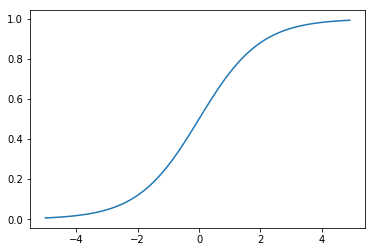

In [4]:
plt.plot(x, y)

https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html

Preprocessing: The original Adult data set has 14 features, among which six are continuous and eight are categorical. In this data set, continuous features are discretized into quantiles, and each quantile is represented by a binary feature. Also, a categorical feature with m categories is converted to m binary features. Details on how each feature is converted can be found in the beginning of each file from this page. [JP98a]
```
# of classes: 2
# of data: 1,605 / 30,956 (testing)
# of features: 123 / 123 (testing)
```

In [5]:
num_features = 123

In [6]:
with open('data/adult/a1a') as f:
    train_raw = f.readlines()

with open('data/adult/a1a.t') as f:
    test_raw = f.readlines()

In [7]:
train_raw[0]

'-1 3:1 11:1 14:1 19:1 39:1 42:1 55:1 64:1 67:1 73:1 75:1 76:1 80:1 83:1 \n'

In [8]:
train_raw[0].split()[1:][0].split(':', 1)

['3', '1']

In [9]:
def process_data(raw_data):
    num_examples = len(raw_data)
    x = np.zeros((num_examples, num_features))
    y = np.zeros((num_examples,))
    for i, line in enumerate(raw_data):
        tokens = line.split()
        y[i] = (int(tokens[0]) + 1) / 2
        for t in tokens[1:]:
            findex, _ = t.split(':', 1)
            findex = int(findex) - 1
            x[i, findex] = 1
    return x, y

In [10]:
x_train, y_train = process_data(train_raw)
x_test, y_test = process_data(test_raw)

In [11]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1605, 123), (1605,), (30956, 123), (30956,))

In [12]:
np.sum(y_train) / len(y_train), np.sum(y_test) / len(y_test)

(0.24610591900311526, 0.24053495283628376)

In [13]:
from common import split_data

In [14]:
batch_size = 64
train_data = split_data(x_train, y_train, batch_size, shuffle=True)
test_data = split_data(x_test, y_test, batch_size, shuffle=True)

In [15]:
train_data[0][0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
def logistic_regression(w, b, x):
    return logistic(np.dot(x, np.squeeze(w)) + b)

In [17]:
def log_likelihood(yhat, y):
    return - np.nansum(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))

objective function $G(w, b)$:

$$- \sum_i {y_i log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) }$$

where $\hat{y} = \frac{1}{1 + \exp(- (wx + b))}$


gradient of $G(w, b)$:

$$
\frac{dG}{dw} = - \sum_i {\frac{ D ( y_i log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) ) }{dw}}
$$

In [18]:
# D(yhat) / dw
# = D((1 + exp(-wx - b))^-1) / dw
# = -1 * (1 + exp(-wx - b))^-2 * D((1 + exp(-wx - b))) / dw
# = - (1 + exp(-wx - b))^-2 * D(exp(-wx - b)) / dw
# = - (1 + exp(-wx - b))^-2 * exp(-wx - b) * D(-wx - b) / dw
# = (1 + exp(-wx - b))^-2 * exp(-wx - b) * x

In [19]:
# D(yhat) / b
# = D((1 + exp(-wx - b))^-1) / db
# = - (1 + exp(-wx - b))^-2 * exp(-wx - b) * D(-wx - b) / db
# = (1 + exp(-wx - b))^-2 * exp(-wx - b)

In [20]:
# D(y log(yhat)) / dw
# = y * D(log(yhat)) / dw
# = y * 1 / yhat * D(yhat) / dw
# = y / yhat * D(yhat) / dw

# D(y log(yhat)) / db
# = y / yhat * D(yhat) / db

In [21]:
# D((1 - y) log(1 - yhat)) / dw
# = (1 - y) D(log(1 - yhat)) / dw
# = (1 - y) * 1 / (1 - yhat) * (-D(yhat) / dw)
# = - (1 - y) / (1 - yhat) * D(yhat) / dw

# D((1 - y) log(1 - yhat)) / db
# = - (1 - y) / (1 - yhat) * D(yhat) / db

In [22]:
def dyhat_db(w, b, x):
    # (1 + exp(-wx - b))^-2 * exp(-wx - b)
    exp_wx_b = np.exp(-np.dot(x, w) - b)
    return (1 + exp_wx_b)**(-2) * exp_wx_b

def dyhat_dw(w, b, x):
    # (1 + exp(-wx - b))^-2 * exp(-wx - b) * x
    dy_db = dyhat_db(w, b, x)
    return dy_db[:, np.newaxis] * x

def gradient(w, b, x, y):
    yhat = logistic_regression(w, b, x)
    y_yhat = y / yhat
    y1_yhat1 = -(1 - y) / (1 - yhat)
    # D(yhat) / db
    dy_dw = dyhat_dw(w, b, x)
    # D(yhat) / dw
    dy_db = dyhat_db(w, b, x)
    #print(dy_dw.shape, dy_db.shape)
    # D(y log(yhat)) / dw
    dylogy_dw = y_yhat[:, np.newaxis] * dy_dw
    # D(y log(yhat)) / db
    dylogy_db = y_yhat * dy_db
    # D((1 - y) log(1 - yhat)) / dw
    d1ylog1y_dw = y1_yhat1[:, np.newaxis] * dy_dw
    # D((1 - y) log(1 - yhat)) / db
    d1ylog1y_db = y1_yhat1 * dy_db
    # dG / dw
    dG_dw = -np.sum(dylogy_dw + d1ylog1y_dw, axis=0)
    # dG / db
    #print(dylogy_db, d1ylog1y_db)
    dG_db = -np.sum(dylogy_db + d1ylog1y_db, axis=0)
    #print(dG_dw.shape, dG_db.shape)
    return dG_dw, dG_db

In [23]:
def sgd_update(w, b, x, y, rate):
    grad_w, grad_b = gradient(w, b, x, y)
#     print(grad_w)
#     print(grad_b)
    w[:] = w - rate * grad_w
    b[:] = b - rate * grad_b
    return w, b

In [24]:
epochs = 100
learning_rate = .001

In [25]:
w = np.random.randn(num_features)
b = np.random.randn(1)
# print(w, b)

In [26]:
for e in range(epochs):
    cumulative_lld = 0
    for bx, by in train_data:
        yhat = logistic_regression(w, b, bx)
        lld = log_likelihood(yhat, by)
        cumulative_lld += lld
        sgd_update(w, b, bx, by, learning_rate)
#         print(w, b)
    print(cumulative_lld)

1451.789982367239
1162.0351315856472
1104.962901251723
1068.4052755569326
1036.8497414946032
1008.4497605912713
982.5910473902312
958.8778021147172
937.0079258550029
916.7407765534596
897.8813753038324
880.2701174029448
863.7752971507188
848.2874155351424
833.7147412558721
819.9798016160761
807.0165860068041
794.7683075570682
783.1856086457565
772.2251228681135
761.8483248728605
752.0206132391246
742.7105820235466
733.8894448265825
725.5305818236345
717.6091855613287
710.1019856869763
702.9870363544999
696.2435529955217
689.8517875967596
683.7929336911956
678.0490540235429
672.6030253319609
667.4384959179571
662.5398526674699
657.8921949551454
653.4813134386487
649.2936721692098
645.3163927525037
641.5372395323053
637.9446049711939
634.5274945888799
631.2755109981046
628.1788367498873
625.2282158580432
622.414934009958
619.7307975805892
617.1681116466286
614.7196572480393
612.3786681677454
610.1388075019019
607.9941442782954
605.9391303544191
603.9685777943547
602.0776368885315
600.261

In [27]:
num_correct = 0.0
num_total = len(y_test)
for tx, ty in test_data:
    yhat = logistic_regression(w, b, tx)
    prediction = (np.sign(yhat - 0.5) + 1) / 2
    num_correct += np.sum(prediction == ty)
print(num_correct / num_total)

0.8307274841710816
